In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from torch import nn

device = "cuda"

2025-04-17 11:41:47.876244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744904507.887551   26408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744904507.891151   26408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 11:41:47.904504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not load bitsandbytes native library: 'NoneType' object has no attribute 'split'
Traceback (most recent call last):
  F

In [2]:
pipe_type = torch.float16 if device == "cuda" else torch.float32
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=pipe_type)
pipe = pipe.to(device)
pipe.enable_attention_slicing() 
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(20)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
prompt = "a futuristic cityscape"
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

In [4]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)


In [5]:
with torch.no_grad():
    latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size
    latents = latents.to(pipe_type) * pipe.scheduler.init_noise_sigma  # match scheduler expectations

/tmp/ipykernel_26408/754967804.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size


In [6]:
text_embeddings.requires_grad_(True)
text_embeddings.retain_grad()

In [7]:
text_embeddings.requires_grad

True

In [8]:
x = latents

In [9]:
import torch.utils.checkpoint as cp
# x_t_list = [x]

def unet_forward(model_input, t, text_embeds):
    return pipe.unet(model_input, t, encoder_hidden_states=text_embeds).sample


for i, t in enumerate(pipe.scheduler.timesteps):
    model_input = pipe.scheduler.scale_model_input(x, t)

    
    print(model_input.requires_grad)

    # dummy = torch.tensor(0.0, requires_grad=True, device=model_input.device)
    # Apply checkpointing
    noise_pred = cp.checkpoint(unet_forward, model_input, t, text_embeddings)

    scheduler_output = pipe.scheduler.step(noise_pred, t, x)
    x = scheduler_output.prev_sample

False
True


/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [10]:
image = scheduler_output.pred_original_sample


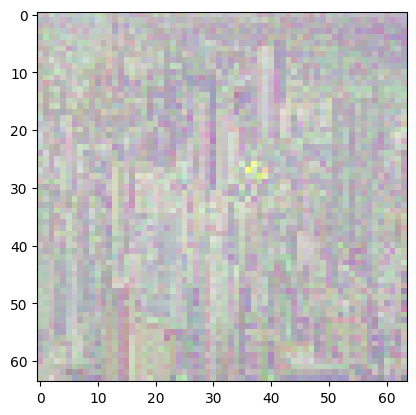

In [11]:
import numpy as np
image = scheduler_output.pred_original_sample
img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32) # Squeeze if you want to remove the channel dimension
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
import matplotlib.pyplot as plt
# Plot using matplotlib
plt.imshow(img_np, cmap='gray')
plt.show()

In [12]:
image_mean = image.mean()
image_mean.backward()

In [13]:
specials = {
    "bos_token": pipe.tokenizer.bos_token,
    "eos_token": pipe.tokenizer.eos_token,
    "pad_token": pipe.tokenizer.pad_token,
    "unk_token": pipe.tokenizer.unk_token,
    "additional_special_tokens": pipe.tokenizer.additional_special_tokens,
}

special_token_ids = set()

# Add basic special tokens
for attr in ["bos_token", "eos_token", "pad_token", "unk_token"]:
    token = getattr(pipe.tokenizer, attr, None)
    if token is not None:
        token_id = pipe.tokenizer.convert_tokens_to_ids(token)
        special_token_ids.add(token_id)

# Add additional special tokens (if any)
for token in pipe.tokenizer.additional_special_tokens:
    token_id = pipe.tokenizer.convert_tokens_to_ids(token)
    special_token_ids.add(token_id)

special_ids_tensor = torch.tensor(list(special_token_ids), device="cpu")
mask = ~torch.isin(text_input.input_ids[0], special_ids_tensor)
importance = (text_embeddings.grad[0, mask] * text_embeddings[0, mask]).norm(dim=-1)
final_importance = importance
if importance.norm() > 0:
    final_importance /= importance.norm()
token_ids = text_input.input_ids[0, mask]
for i, token_id in enumerate(token_ids):
    imp = final_importance[i]
    word = pipe.tokenizer.decode(token_id)
    print(f"Token: {word}, importance: {imp}")


Token: a, importance: 0.10198974609375
Token: futuristic, importance: 0.460693359375
Token: cityscape, importance: 0.8818359375
